In [7]:
# ==============================
# Importing all required libraries
# ==============================
import sys
import os
import warnings
warnings.filterwarnings("ignore")

# Core data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn components
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, precision_score, recall_score, accuracy_score,
                             confusion_matrix, classification_report, RocCurveDisplay,
                             PrecisionRecallDisplay, roc_auc_score)
from sklearn.feature_selection import mutual_info_classif

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Advanced Models for Comparison
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Print versions for reproducibility
print(" Environment Setup:")
print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

# Global settings for reproducibility
RANDOM_STATE = 42
PRIMARY_METRIC = "f1"
SEED = RANDOM_STATE

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports and setup completed successfully!\n")

 Environment Setup:
Python: 3.12.12
Pandas: 2.2.2
NumPy: 2.0.2
✅ All imports and setup completed successfully!



In [8]:
# ==============================
# DATA LOADING & INITIAL EXPLORATION
# ==============================

TRAIN_PATH = "dataset_A_training.csv"
TEST_PATH = "dataset_A_testing.csv"

print(" Loading datasets...")
try:
    train_data = pd.read_csv(TRAIN_PATH)
    test_data = pd.read_csv(TEST_PATH)

    print("✅ Data loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please check the file paths and try again.")
    # If running in Colab, you might need to upload files first
    # from google.colab import files
    # uploaded = files.upload()

# Basic dataset information
print(f"\n Dataset Shapes:")
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

print(f"\n Training Data Preview:")
display(train_data.head())

print(f"\n Training Data Info:")
train_data.info()

 Loading datasets...
✅ Data loaded successfully!

 Dataset Shapes:
Training data: (4756, 31)
Test data: (4749, 30)

 Training Data Preview:


,respondent_id,flu_concern,flu_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,employment_sector,seasonal_vaccine
0,1,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,Non-MSA,0.0,0.0,entertainment,0
1,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Male,NaN,Not Married,Rent,Employed,"MSA, Principle City",1.0,0.0,real_estate,0
2,3,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,Male,"> $75,000",Married,Own,Not in Labor Force,"MSA, Not Principle City",1.0,0.0,NaN,0
3,4,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Male,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,2.0,utilities,1
4,5,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Not Principle City",2.0,0.0,NaN,0



 Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756 entries, 0 to 4755
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                4756 non-null   int64  
 1   flu_concern                  4744 non-null   float64
 2   flu_knowledge                4733 non-null   float64
 3   behavioral_antiviral_meds    4742 non-null   float64
 4   behavioral_avoidance         4724 non-null   float64
 5   behavioral_face_mask         4753 non-null   float64
 6   behavioral_wash_hands        4748 non-null   float64
 7   behavioral_large_gatherings  4747 non-null   float64
 8   behavioral_outside_home      4747 non-null   float64
 9   behavioral_touch_face        4737 non-null   float64
 10  doctor_recc_seasonal         4435 non-null   float64
 11  chronic_med_condition        4568 non-null   float64
 12  child_under_6_months         4604 non-null   float64
 

Target variable: seasonal_vaccine
ID column: respondent_id

 Feature Matrix Shape: (4756, 29)
Target Vector Shape: (4756,)

 Column Types:
Categorical features (10): ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa', 'employment_sector']
Numeric features (19): ['flu_concern', 'flu_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']

Target Distribution:


,Count,Percentage
seasonal_vaccine,,
1,2551,53.637511
0,2205,46.362489


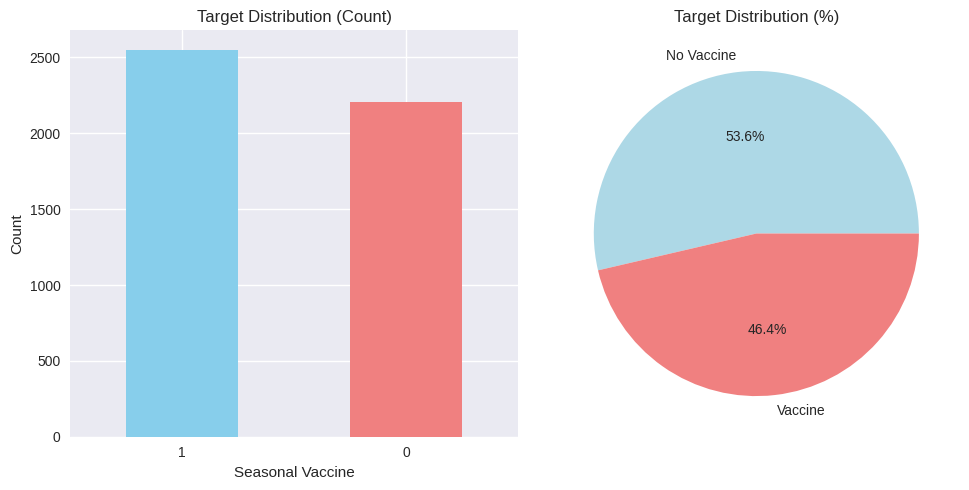

In [9]:
# ==============================
# DATA UNDERSTANDING & SETUP
# ==============================

# Define key columns
TARGET_COL = "seasonal_vaccine"
ID_COL = "respondent_id"

print(f"Target variable: {TARGET_COL}")
print(f"ID column: {ID_COL}")

# Verify required columns exist
assert TARGET_COL in train_data.columns, f"Target column '{TARGET_COL}' not found in training data!"
assert ID_COL in train_data.columns, f"ID column '{ID_COL}' not found in training data!"

# Prepare features and target
X = train_data.drop(columns=[TARGET_COL, ID_COL])  # Remove target and ID for modeling
y = train_data[TARGET_COL].astype(int)  # Ensure target is integer
X_test = test_data.drop(columns=[ID_COL])  # Remove ID from test data

print(f"\n Feature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")

# Identify column types automatically
categorical_columns = X.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n Column Types:")
print(f"Categorical features ({len(categorical_columns)}): {categorical_columns}")
print(f"Numeric features ({len(numeric_columns)}): {numeric_columns}")

# Check target distribution
print(f"\nTarget Distribution:")
target_counts = y.value_counts()
target_percentages = y.value_counts(normalize=True) * 100

target_summary = pd.DataFrame({
    'Count': target_counts,
    'Percentage': target_percentages
})
display(target_summary)

# Visualize target distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
target_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Distribution (Count)')
plt.xlabel('Seasonal Vaccine')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(target_counts, labels=['No Vaccine', 'Vaccine'], autopct='%1.1f%%',
        colors=['lightblue', 'lightcoral'])
plt.title('Target Distribution (%)')

plt.tight_layout()
plt.show()